In [1]:
%matplotlib notebook
import numpy as np
import time
from scipy.optimize import minimize

### Introduction

In this assingment we will use different technique to solve an optimization problem. In particular, we use ridge regression under a least-squares approach. For that, we need to generate the dataset that contains 50000 observations and 1000 variables. The observations are uniformly distributed in the range of 0 to 10. The coefficients are also uniformly distributed between -2 and 2. Finally, the error term of the least-squares model is normally distributed with mean 0 and standard deviation 1. The response variable is generated from the previous data:

$$Y = X \beta + \epsilon$$

In [2]:
#number of observation and variables
nvar = 1000
nobs = 50000

#set seed for reproducibility purposes
np.random.seed(1)

#generates dataset
x0 = np.ones((nobs,1))
x1 = np.random.uniform(low=0, high=10, size=(nobs,nvar))
x = np.concatenate((x0,x1), axis=1)
beta = np.random.uniform(low=-2, high=2, size=(nvar+1,1))
eps = np.random.normal(loc=0, scale=1, size=(nobs,1))
y = np.dot(x,beta) + eps

The ridge regression problem is formulated as an optimization problem without constraints as:

$$\min_\beta \| Y-X \beta \|_{2}^{2} + \rho \| \beta \|_{2}^{2}$$

where the second term is added for the shake of reducing the variance of the coefficients when the problem suffers from collinearity. 

### Part a

The analytical solution of the problem is:

$$\hat{\beta}=\left(X^{\prime} X+\rho I\right)^{-1}X^{\prime} Y$$

We can compute it as follows, setting the regularization paramter to $\rho = 1000$:

In [3]:
rho = 1000

beta_a = np.dot( np.dot( np.linalg.inv( np.dot(x.T,x) + rho*np.eye(nvar+1)), x.T), y)

We will use these values as a benchmark and we will compare them with the result of other methods.

### Part b

To approach the problem as an optimization problem we need to implement the function to minimize and its derivates:

In [4]:
#objective function. ridge regression
def ridge_regression_of(beta,x,y,rho):
    beta = np.reshape(beta, newshape=(len(beta),1)) #reshape so beta is a matrix instead of a vector
    z = y - np.dot(x,beta)
    of_value = np.dot(z.T,z) + rho*np.dot(beta.T,beta)
    return of_value

#gradient of the objective function. ridge regression
def ridge_regression_grad_of(beta,x,y,rho):
    beta = np.reshape(beta, newshape=(len(beta),1))
    grad = -2. * np.dot( (y - np.dot(x,beta)).T, x) + 2.*rho*beta.T
    return np.squeeze(grad)

#hessian matrix of the objective function. ridge regression
def ridge_regression_hess_of(beta,x,y,rho):
    beta = np.reshape(beta, newshape=(len(beta),1))
    hess = 2. * np.dot(x.T,x) + 2. * rho
    return hess

The coefficients can be estimated using *Scipy* package and *minimize* function. It implements different methods to approach the problem. We are going to use *Nelder-Mead*, *BFGS*, *L-BFGS-B*, *CG* and *Newton CG*:

In [5]:
#initial value for beta
beta_init = np.zeros(nvar+1)

In [6]:
#conjugate gradient
time_start = time.process_time()
beta_scipy_cg = minimize(ridge_regression_of, beta_init, args=(x,y,rho), method='CG', jac=ridge_regression_grad_of, options={'disp': True})
time_scipy_cg = time.process_time() - time_start

         Current function value: 1280463.797536
         Iterations: 22
         Function evaluations: 54
         Gradient evaluations: 53


In [7]:
#newton conjugate gradient
time_start = time.process_time()
beta_scipy_newtoncg = minimize(ridge_regression_of, beta_init, args=(x,y,rho), method='Newton-CG', jac=ridge_regression_grad_of, hess=ridge_regression_hess_of, options={'disp':True})
time_scipy_newtoncg = time.process_time() - time_start

Optimization terminated successfully.
         Current function value: 1280464.119392
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 20
         Hessian evaluations: 10


In [8]:
#bfgs
time_start = time.process_time()
beta_scipy_bfgs = minimize(ridge_regression_of, beta_init, args=(x,y,rho), method='BFGS', jac=ridge_regression_grad_of, options={'disp': True})
time_scipy_bfgs = time.process_time() - time_start

         Current function value: 1280463.797549
         Iterations: 346
         Function evaluations: 736
         Gradient evaluations: 735


In [9]:
#l-bfgs
time_start = time.process_time()
beta_scipy_lbfgs = minimize(ridge_regression_of, beta_init, args=(x,y,rho), method='L-BFGS-B', jac=ridge_regression_grad_of, options={'disp': True})
time_scipy_lbfgs = time.process_time() - time_start
beta_scipy_lbfgs

      fun: array([[1280464.12378359]])
 hess_inv: <1001x1001 LbfgsInvHessProduct with dtype=float64>
      jac: array([-35.94738328,  -4.68501833,   2.12111097, ...,   0.42248703,
         2.14578832,  -1.42922489])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 50
      nit: 42
   status: 0
  success: True
        x: array([ 0.0084759 ,  1.04448654,  0.04139102, ..., -0.65265345,
       -1.18572373, -1.46697377])

We can see that all the solvers have achieve almost the same value of the loss function. However, they have achieved it with a different number of iterations and evaluations of the functions. The regularization parameter is set to $\rho = 1000$ for all the methods.

**Iterations**: the method with the lowest number of iterations is Newton-CG with only 10 iterations. This is because it converges very fast and it only needs a few iterations, since the method uses a descent direction that minimizes a quadratic approximation of the objective function. It is followed by CG with 22 iterations which uses a linear approximation instead of quadratic, making it a method that requires more iterations to converge to the optimal solution. L-BFGS has carried out 42 iterations and finally BFGS 346 iterations.

**Function evaluations**: again Newton-CG is the method with the lowest number of function evaluations with 11, CG has carried out 54 evaluations and BFGS 736. This is due to the fact that BFGS uses an approximation of the hessian matrix with the objective function and the gradient. Thus, it requires a lot more function and gradient evaluations but it is cheaper than Newton-CG.

**Gradient evaluation**: the analysis and results are the same as for the objective function.

**Execution time**: below we can see that the computational time varies vastly with the method used. L-BGFS and CG are far the more effiecient ones for our case. In the case of L-BGFS, it a variant of BGFS that uses less memory. Our problem has a lot of variables and observations, so in this case this algorithm performs very well regarding the computational time. CG is also very fast because it does not use the hessian, saving a lot of operations during each iteration. That is the reason for CG beeing faster than Newton-CG, although Newton-CG has done less iterations. Finally, BFGS is the slowest one, with a lot of calls to the functions.

In [10]:
print('time of execution of CG: {:.3f}'.format(time_scipy_cg))
print('time of execution of Newton-CG: {:.3f}'.format(time_scipy_newtoncg))
print('time of execution of BFGS: {:.3f}'.format(time_scipy_bfgs))
print('time of execution of L-BFGS: {:.3f}'.format(time_scipy_lbfgs))

time of execution of CG: 12.859
time of execution of Newton-CG: 26.953
time of execution of BFGS: 284.625
time of execution of L-BFGS: 12.156


Regarding the coefficients, we can print the first 5 coefficients of each method and compare them

In [11]:
for i in range(5):
    print('beta_{}: benchmark = {:.3f}, CG = {:.3f}, Newton-CG = {:.3f}, BFGS = {:.3f}, L-BFGS = {:.3f}'.format(i,beta_a[i][0], beta_scipy_cg.x[i], beta_scipy_newtoncg.x[i], beta_scipy_bfgs.x[i], beta_scipy_lbfgs.x[i]))

beta_0: benchmark = 0.026, CG = 0.026, Newton-CG = 0.008, BFGS = 0.026, L-BFGS = 0.008
beta_1: benchmark = 1.044, CG = 1.044, Newton-CG = 1.044, BFGS = 1.044, L-BFGS = 1.044
beta_2: benchmark = 0.041, CG = 0.041, Newton-CG = 0.041, BFGS = 0.041, L-BFGS = 0.041
beta_3: benchmark = -0.131, CG = -0.131, Newton-CG = -0.131, BFGS = -0.131, L-BFGS = -0.131
beta_4: benchmark = 1.554, CG = 1.554, Newton-CG = 1.554, BFGS = 1.554, L-BFGS = 1.554


The only coefficient that is slightly different is *beta_0* and only with the methods *Newton-CG* and *L-BFGS*. The rest seem to be exactly the same. Finally, we can compute the root mean sqaure error of the coefficients using the values of the analytical solution as the benchmark to compare with, and check is the previous assumption is true. Below we can see that all the methods have almost no errors in their coefficients.

In [12]:
print('RMSE of CG: {:.3f}'.format(np.sqrt(np.mean((beta_a.T - beta_scipy_cg.x)**2))))
print('RMSE of Newton-CG: {:.3f}'.format(np.sqrt(np.mean((beta_a.T - beta_scipy_newtoncg.x)**2))))
print('RMSE of BFGS: {:.3f}'.format(np.sqrt(np.mean((beta_a.T - beta_scipy_bfgs.x)**2))))
print('RMSE of L-BFGS: {:.3f}'.format(np.sqrt(np.mean((beta_a.T - beta_scipy_lbfgs.x)**2))))

RMSE of CG: 0.000
RMSE of Newton-CG: 0.001
RMSE of BFGS: 0.000
RMSE of L-BFGS: 0.001


### Part c

Now we will add bounds to the value of the coefficients. Since they have been sampled between -2 and 2, we will limit their value between -1.5 and 1.5. *L-BFGS-B* and *TCN* are the algorithms chosen to solve the problem.

In [13]:
#setting bounds
bnds = []
for _ in range(nvar+1):
    bnds.append([-1.5,1.5])

#l-bfgs-b
time_start = time.process_time()
beta_scipy_lbfgsb = minimize(ridge_regression_of, beta_init, args=(x,y,rho), method='L-BFGS-B', jac=ridge_regression_grad_of, bounds=bnds, options={'disp': True})
time_scipy_lbfgsb = time.process_time() - time_start
beta_scipy_lbfgsb

      fun: array([[8157635.15015978]])
 hess_inv: <1001x1001 LbfgsInvHessProduct with dtype=float64>
      jac: array([-130.08323519, -496.49577492, -584.9019442 , ..., -568.32343675,
       -539.42921166, -590.44772503])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 136
      nit: 111
   status: 0
  success: True
        x: array([ 0.64159278,  1.0369088 ,  0.05088421, ..., -0.63201959,
       -1.17001186, -1.44600848])

In [14]:
#tnc
time_start = time.process_time()
beta_scipy_tcn = minimize(ridge_regression_of, beta_init, args=(x,y,rho), method='TNC', jac=ridge_regression_grad_of, bounds=bnds, options={'disp': True})
time_scipy_tcn = time.process_time() - time_start
beta_scipy_tcn

     fun: array([[8157634.13965719]])
     jac: array([-0.00928893, -0.04231505, -0.0433899 , ..., -0.04464799,
       -0.04398121, -0.04751973])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 705
     nit: 222
  status: 1
 success: True
       x: array([ 0.6502029 ,  1.03683718,  0.05090945, ..., -0.63200902,
       -1.1700499 , -1.44597426])

The inclusion of the bounds makes the value of the function larger than the optimal (when coefficients can take their optimal values). Previously the optimal value of the loss function was around 1280463 and now it is around 8157635 which is 6 times larger. This has also an effect on the coefficients. Let's print the first 5 coefficients of the three methods:

In [15]:
for i in range(5):
    print('beta_{}: benchmark = {:.3f}, L-BFGS-B = {:.3f}, TCN = {:.3f}'.format(i,beta_a[i][0], beta_scipy_lbfgsb.x[i], beta_scipy_tcn.x[i]))

beta_0: benchmark = 0.026, L-BFGS-B = 0.642, TCN = 0.650
beta_1: benchmark = 1.044, L-BFGS-B = 1.037, TCN = 1.037
beta_2: benchmark = 0.041, L-BFGS-B = 0.051, TCN = 0.051
beta_3: benchmark = -0.131, L-BFGS-B = -0.084, TCN = -0.084
beta_4: benchmark = 1.554, L-BFGS-B = 1.500, TCN = 1.500


The coefficient *beta 0* differs quite when bounds are added with respect to the benchmark. The rest of the coefficients remain very close to their benchmark associates when the analytical value is in the range -1.5 to 1.5. That is, when a coefficient is outside the interval it is truncated by the bound to the maximum or the minimum value as we can see with *beta_4*. The change in all these coefficients is what makes the intercept to be different. Finally, comparing the RMSE we have that the RMSE of the methods with bounded coefficients have a larger error, which actually makes sense since unbounded methods yielded exactly the true coefficients and now they are restricted.

In [16]:
print('RMSE of CG: {:.3f}'.format(np.sqrt(np.mean((beta_a.T - beta_scipy_cg.x)**2))))
print('RMSE of L-BFGS-B: {:.3f}'.format(np.sqrt(np.mean((beta_a.T - beta_scipy_lbfgsb.x)**2))))
print('RMSE of TCN: {:.3f}'.format(np.sqrt(np.mean((beta_a.T - beta_scipy_tcn.x)**2))))

RMSE of CG: 0.000
RMSE of L-BFGS-B: 0.132
RMSE of TCN: 0.132


Comparing the execution time we can see that *L-BFGS-B* is way faster than *TNC*. However, *L-BFGS-B* is lower when bounds are added with respect to the previous one without bounds.

In [17]:
print('time of execution of L-BFGS-B: {:.3f}'.format(time_scipy_lbfgsb))
print('time of execution of TCN: {:.3f}'.format(time_scipy_tcn))

time of execution of L-BFGS-B: 33.859
time of execution of TCN: 168.500


### Part d

We will implement and run the Gradient method, Newton method and Quasi-Newton method and then we will compare them. To do that we set some parameters so they compete with the same rules. The stopping criteria is set as the percentage of change of the objective function between one iteration and the previous one and is set to $\epsilon = 10^{-3}$. The maximun number of iterations allowed is 1000 and the regularization parameter is $\rho = 1000$.

In [18]:
#gradient method 
import time

#set parameters
n_iter = 0 #number of iterations
max_iter = 1000 #number of maximum iterations
tol = 1e5 #initial value of tolerance
rho = 1000
eps = 1e-4

#initialize variables
of = 1000
beta_init = np.zeros(nvar+1)
of_iter = np.zeros(max_iter)
tol_iter= np.zeros(max_iter)
alpha_iter = np.zeros(max_iter)

#initialize update rule variables
beta = np.copy(beta_init)

#algorithm
time_start = time.process_time()
for i in range(max_iter):
    if tol > eps:
        
        #step 1. obtain descent direction
        gradient = ridge_regression_grad_of(beta,x,y,rho)
        d = - gradient
        
        #step 2. obtain step length with armijo rule
        sigma = 1e-3
        gamma = 0.5
        alpha = 1
        while (ridge_regression_of(beta + alpha * d,x,y,rho) > ridge_regression_of(beta,x,y,rho) + alpha * sigma * np.dot(gradient,d)):
            alpha = alpha * gamma
        
        #step 3. step direction and length and update
        beta = beta + alpha * d
        
        #step 4. tolerance
        #tol = np.linalg.norm(gradient,ord=2)
        of_new = ridge_regression_of(beta,x,y,rho)
        tol = np.absolute((of_new - of)/of) 
        of = of_new 
        
        #step 5. store data into arrays
        of_iter[i] = of
        tol_iter[i] = tol
        alpha_iter[i] = alpha
        n_iter += 1

time = time.process_time() - time_start

In [19]:
print('RMSE of Gradient method: {:.3f}'.format(np.sqrt(np.mean((beta_a.T - beta)**2))))
print('time elapsed =',time)
print('iterations =',n_iter)
print('Tolerance =',tol[0][0])

RMSE of Gradient method: 1.093
time elapsed = 59.65625
iterations = 12
Tolerance = 5.131270489504467e-05


C:\Users\sesig\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\sesig\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


<Figure size 432x288 with 0 Axes>

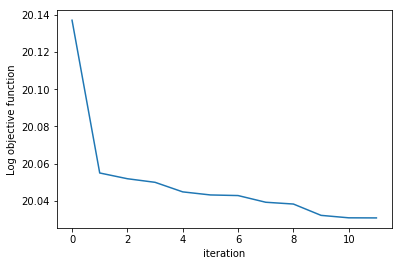

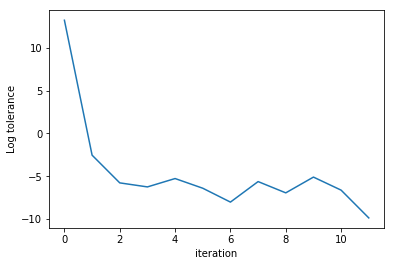

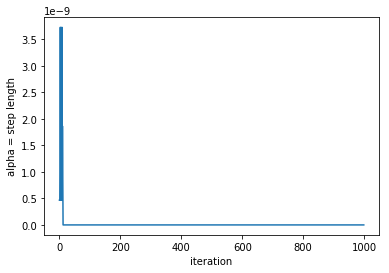

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.log(of_iter))
plt.xlabel('iteration')
plt.ylabel('Log objective function')
plt.figure()
plt.plot(np.log(tol_iter))
plt.xlabel('iteration')
plt.ylabel('Log tolerance')
plt.figure()
plt.plot(alpha_iter)
plt.xlabel('iteration')
plt.ylabel('alpha = step length')
plt.figure()

In [21]:
#newton method 
import time

#set parameters
n_iter = 0 #number of iterations
max_iter = 1000 #number of maximum iterations
tol = 1e5 #initial value of tolerance
rho = 1000
eps = 1e-3

#initialize variables
of = 100
beta_init = np.zeros(nvar+1)
of_iter = np.zeros(max_iter)
tol_iter= np.zeros(max_iter)
alpha_iter = np.zeros(max_iter)

#initialize update rule variables
beta = np.copy(beta_init)

#algorithm
time_start = time.process_time()
for i in range(max_iter):
    if tol > eps:
        
        #step 1. obtain descent direction
        gradient = ridge_regression_grad_of(beta,x,y,rho)
        hessian = ridge_regression_hess_of(beta,x,y,rho)
        d = - np.dot(np.linalg.inv(hessian),gradient)
        
        #step 2. obtain step length with armijo rule
        sigma = 1e-3
        gamma = 0.5
        alpha = 1
        while (ridge_regression_of(beta + alpha * d,x,y,rho) > ridge_regression_of(beta,x,y,rho) + alpha * sigma * np.dot(gradient,d)):
            alpha = alpha * gamma
        
        #step 3. step direction and length and update
        beta = beta + alpha * d
        
        #step 4. tolerance
        #tol = np.linalg.norm(gradient,ord=2)
        of_new = ridge_regression_of(beta,x,y,rho)
        tol = np.absolute( (of_new - of)) 
        of = of_new 
        
        #step 5. store data into arrays
        of_iter[i] = of
        tol_iter[i] = tol
        alpha_iter[i] = alpha
        n_iter += 1

time = time.process_time() - time_start

In [22]:
print('RMSE of Newton method: {:.3f}'.format(np.sqrt(np.mean((beta_a.T - beta)**2))))
print('time elapsed =',time)
print('iterations = ',n_iter)
print('Tolerance =',tol[0][0])

RMSE of Newton method: 0.000
time elapsed = 74.25
iterations =  20
Tolerance = 0.0006899628788232803


C:\Users\sesig\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\sesig\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


<Figure size 432x288 with 0 Axes>

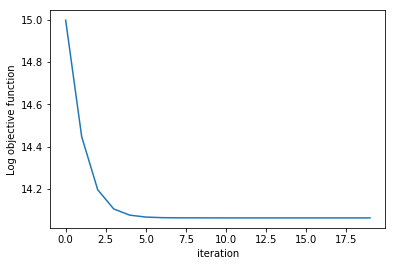

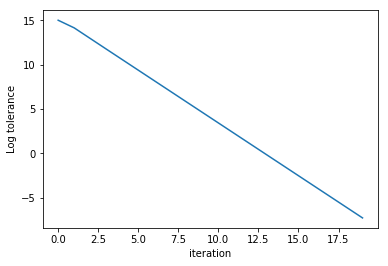

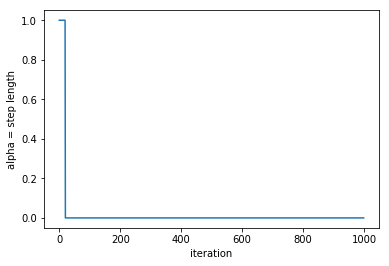

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.log(of_iter))
plt.xlabel('iteration')
plt.ylabel('Log objective function')
plt.figure()
plt.plot(np.log(tol_iter))
plt.xlabel('iteration')
plt.ylabel('Log tolerance')
plt.figure()
plt.plot(alpha_iter)
plt.xlabel('iteration')
plt.ylabel('alpha = step length')
plt.figure()

In [25]:
#quasinewton method 
import time

#set parameters
n_iter = 0 #number of iterations
max_iter = 1000 #number of maximum iterations
tol = 1e5 #initial value of tolerance
rho = 1000
eps = 1e-3

#initialize variables
of = 100
beta_init = np.zeros(nvar+1)
of_iter = np.zeros(max_iter)
tol_iter= np.zeros(max_iter)
alpha_iter = np.zeros(max_iter)
error_iter = np.zeros(max_iter)

#initialize update rule variables
b = np.eye(nvar+1)
beta = np.copy(beta_init)
gradient = ridge_regression_grad_of(beta,x,y,rho)

#algorithm
time_start = time.process_time()
for i in range(max_iter):
    if tol > eps:
        
        #step 1. obtain descent direction
        d = - np.dot(b,gradient)
        
        #step 2. obtain step length with armijo rule
        sigma = 1e-3
        gamma = 0.5
        alpha = 0.1
        while (ridge_regression_of(beta + alpha * d,x,y,rho) > ridge_regression_of(beta,x,y,rho) + alpha * sigma * np.dot(gradient,d)):
            alpha = alpha * gamma
        
        #step 3. step direction and length and update
        s = alpha * d
        beta_new = beta + s
        
        #step 4. difference in gradients
        gradient_new = ridge_regression_grad_of(beta_new,x,y,rho)
        r = gradient_new - gradient
        
        #step 5. update the inverse of the hessian matrix b
        aux1 = np.dot(s.T,r)
        aux2 = ( aux1 + np.dot(np.dot(r.T,b),r) ) * np.outer(s,s.T) / aux1**2
        np.outer(np.dot(b,r),s.T)
        aux3 = ( np.outer(np.dot(b,r),s.T) + np.dot(np.outer(s,r.T),b)) / aux1  
        b_new = b + aux2 - aux3
        b = np.copy(b_new)
        beta = np.copy(beta_new)
        gradient = np.copy(gradient_new)
        
        #step 6. tolerance
        of_new = ridge_regression_of(beta,x,y,rho)
        tol = np.absolute(of_new - of) 
        of = of_new 
        
        #step 7. stored data in arrays
        of_iter[i] = of
        tol_iter[i] = tol
        alpha_iter[i] = alpha
        error_iter[i] = np.linalg.norm(beta_a - beta, ord = 2) / np.linalg.norm(beta_a, ord = 2)
        n_iter += 1

time = time.process_time() - time_start

In [26]:
print('RMSE of Quasi-Newton BFGS method: {:.3f}'.format(np.sqrt(np.mean((beta_a.T - beta)**2))))
print('time elapsed =',time)
print('iterations = ',n_iter)
print('Tolerance =',tol[0][0])

RMSE of Quasi-Newton BFGS method: 0.000
time elapsed = 380.015625
iterations =  100
Tolerance = 0.00021961773745715618


C:\Users\sesig\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\sesig\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


Text(0,0.5,'Alpha = step length')

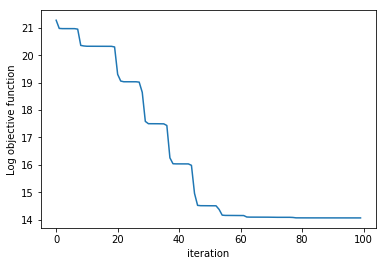

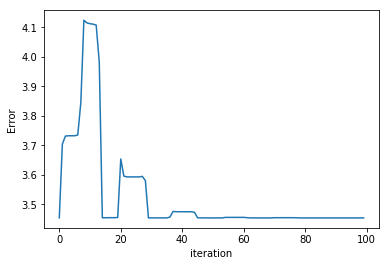

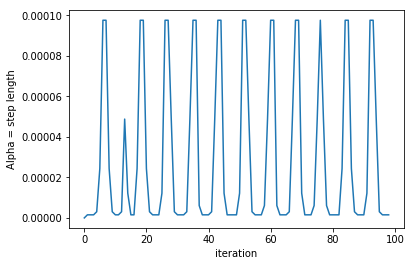

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.log(of_iter))
plt.xlabel('iteration')
plt.ylabel('Log objective function')
plt.figure()
plt.plot(np.log(error_iter))
plt.xlabel('iteration')
plt.ylabel('Error')
plt.figure()
plt.plot(alpha_iter[:n_iter-1])
plt.xlabel('iteration')
plt.ylabel('Alpha = step length')

First let's compare the time performance of each algorithm. Gradient method is the fastest one, then it is followed by Newton method and the slowest one is Quasi-newton. In practice, Quasi-Newton should be faster but maybe the implementation can be optimize so it outperforms Newton method. Regarding the number of iteration, Quasi-Newton method carried out 100 iterations, Newton method 20 iterations and Gradient method 12 iterations. The stopping criteria and the tolerance are important in this aspect as they determine how many interactions an method is going to need before convergence is achieved. Measuring RMSE as we in the previous part we have that RMSE of the Gradient method is 1, 0 for Newton method and 0 for Quasi-Newton method. This difference is due to the stopping criteria we have chosen and the tolerance. Since the gradient method uses a linear approximation of the function it is expected to converge slower than Newton and Quasi-Newton. The plots below each algorithm represent the value of the objective function at each iteration, the value of the tolerance and the value of $\alpha$ (steplength) respectively. To conclude and with this setting and implementation, we can say that Newton method is a good choice.

### Part e

This part contains the implementation of Coordinate descent, Stochastic Gradient, Mini Batch gradient and Stochastic Gradient with momentum. Since these methods require us to set more parameters and it is difficult to test each algorithm under such a large data set, I am finding difficulties to find the perfect value for parameters and each evaluation takes too long. For example, the coordinate descent algorithm uploaded at Aula Global took more than one minute to run with a data set of only 10 variables and 1000 observations. For that reason, and to be able to compare the results, we will create the a new data set of 10 variables and 500 observations. The regularization parameter is now set to 1. In this algorithms the stopping criteria is a key step, and some of them can not use the classic one of computing the gradient and checking its deviation from 0. For example, Stochastic Gradient uses only one observation drawn randomly from the sample, so the gradient will behave erratically with the interactions. Thus, it may not be a good stopping criteria. In the results we will comment the stopping criteria used for each algorithm. Let's start with Coordinate Descent:

In [28]:
#Coordinate descent method 

#number of observation and variables
nvar = 10
nobs = 500

#set seed for reproducibility purposes
np.random.seed(1)

#generates dataset
x0 = np.ones((nobs,1))
x1 = np.random.uniform(low=0, high=10, size=(nobs,nvar))
x = np.concatenate((x0,x1), axis=1)
beta = np.random.uniform(low=-2, high=2, size=(nvar+1,1))
eps = np.random.normal(loc=0, scale=1, size=(nobs,1))
y = np.dot(x,beta) + eps

rho = 1

beta_a = np.dot( np.dot( np.linalg.inv( np.dot(x.T,x) + rho*np.eye(nvar+1)), x.T), y)

import time

#define gradient (more efficient to multiply by a vector than a matrix)
def ridge_regression_grad_of_dd(beta,x,y,rho,index):
    beta = np.reshape(beta, newshape=(len(beta),1))
    grad_index = -2. * np.dot( (y - np.dot(x,beta)).T, x[:,index]) + 2. * rho * beta[index] #avoids computing the hole matrix x and just uses one column
    grad = np.zeros((len(beta),1))
    grad[index] = grad_index
    return np.squeeze(grad)

#set parameters
n_iter = 0 #number of iterations
max_iter = 1000000 #number of maximum iterations
tol = 1e5 #initial value of tolerance
eps = 1e-8
alpha = 1e-5
x_shape = np.shape(x)
a = x_shape[0]
b = x_shape[1]

#initialize variables
of = 100
beta_init = np.zeros(nvar+1)
of_iter = np.zeros(max_iter)
tol_iter= np.zeros(max_iter)
alpha_iter = np.zeros(max_iter)
error_iter = np.zeros(max_iter)

#initialize update rule variables
beta = np.copy(beta_init)

#algorithm
time_start = time.process_time()
for i in range(max_iter):
    if tol > eps:
    
        #step 1. select at random which coefficient is going to be updated and compute the gradient
        k = np.random.randint(b)
        gradient = ridge_regression_grad_of_dd(beta,x,y,rho,k)

        #step 2. compute descent direction and update coefficients
        d = - gradient
        beta = beta + alpha * d

        #step 3. stopping criteria
        of_new = ridge_regression_of(beta,x,y,rho)
        # tol = np.absolute( (of_new - of) / of) 
        tol = np.linalg.norm(gradient, ord=2)
        of = of_new 

        #step 4. store results
        of_iter[i] = of
        tol_iter[i] = tol
        error_iter[i] = np.linalg.norm(beta_a - beta, ord = 2) / np.linalg.norm(beta_a, ord = 2)
        n_iter += 1

time = time.process_time() - time_start

The maximum number of iterations is set to one million, the step length to $\alpha = 10^{-5}$ and the tolerance to $\epsilon = 10^{-8}$. Since we are updating the gradient in one direction at each iteration, we can use it as a stopping criteria because when it is close to zero then the coefficient of each direction has been optimized. Under this setting the algorithm took 76 seconds and almost 300.000 iterations. Optimizing only one direction each iteration makes the algorithm to require a lot of iterations. However it converge quickly given the tolerance we have set. At the end we have that the RMSE is 0 so the algorithm has converge and coefficients match with the analytical values. I have also tried with less restricted values for the tolerance as $\epsilon = 10^{-3}$ and it converges really quickly, around just 1 second. However the RMSE was around 0.2 which is significantly different than the analytical solution.

In [29]:
print('RMSE of Coordinate Descent method: {:.3f}'.format(np.sqrt(np.mean((beta_a.T - beta)**2))))
print('time elapsed =',time)
print('iterations = ',n_iter)
print('Tolerance =',tol)

RMSE of Coordinate Descent method: 0.000
time elapsed = 52.90625
iterations =  278685
Tolerance = 3.0735081146815446e-09


The first plot below shows the log of the objective function at each iteration. There is a big drop at the beggining and then it remains more or less constant. That means that the algorithm has given big steps at the beggining and then it slows down the convergence. To see that easily, the second plot contains just the first 1000 iterations and it is now clear the progression. Finally, the third plot shows the error of the last 100 iterations and how the coefficients converge to the analytical value.

C:\Users\sesig\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


<Figure size 432x288 with 0 Axes>

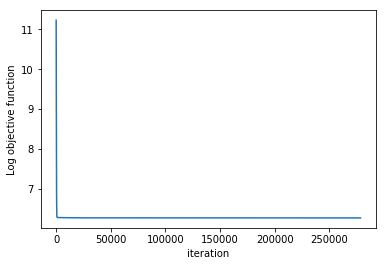

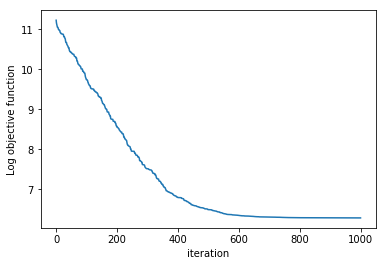

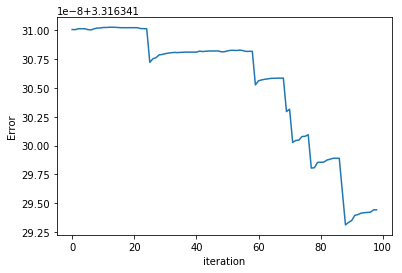

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.log(of_iter))
plt.xlabel('iteration')
plt.ylabel('Log objective function')
plt.figure()
plt.plot(np.log(of_iter[:1000]))
plt.xlabel('iteration')
plt.ylabel('Log objective function')
plt.figure()
plt.plot(error_iter[n_iter-100:n_iter-1])
plt.xlabel('iteration')
plt.ylabel('Error')
plt.figure()

The next step is to code Stochastic gradient. At each iteration it only uses one observation of the hole data set to compute the gradient. Thus, we have to modify the gradient function because now the response is a scalar instead of a vector and the observation matrix is a vector instead of a matrix.

In [31]:
#Stochastic gradient 

#gradient of the objective function. ridge regression
def ridge_regression_grad_of_sg(beta,x,y,rho):
    grad = -2. *  (y - np.dot(x,beta)) * x + 2. * rho * beta
    return np.squeeze(grad)

#number of observation and variables
nvar = 10
nobs = 500

#set seed for reproducibility purposes
np.random.seed(1)

#generates dataset
x0 = np.ones((nobs,1))
x1 = np.random.uniform(low=0, high=10, size=(nobs,nvar))
x = np.concatenate((x0,x1), axis=1)
beta = np.random.uniform(low=-2, high=2, size=(nvar+1,1))
eps = np.random.normal(loc=0, scale=1, size=(nobs,1))
y = np.dot(x,beta) + eps

rho = 1

beta_a = np.dot( np.dot( np.linalg.inv( np.dot(x.T,x) + rho*np.eye(nvar+1)), x.T), y)

import time

#set parameters
n_iter = 0 #number of iterations
max_iter = 100000 #number of maximum iterations
tol = 1e5 #initial value of tolerance
eps = 1e-8
alpha = 1e-5
x_shape = np.shape(x)
a = x_shape[0]
b = x_shape[1]

#initialize variables
of = 100
beta_init = np.zeros(nvar+1)
of_iter = np.zeros(max_iter)
tol_iter= np.zeros(max_iter)
alpha_iter = np.zeros(max_iter)
error_iter = np.zeros(max_iter)

#initialize update rule variables
beta_new = np.copy(beta_init)
beta = np.copy(beta_init)
beta[:] = 1000

#algorithm
time_start = time.process_time()
for i in range(max_iter):
    if tol > eps:
    
        #step 1. select at random sample is going to be used to compute the gradient
        k = np.random.randint(a)
        gradient_new = ridge_regression_grad_of_sg(beta_new,x[k,:],y[k],rho)

        #step 2. compute descent direction and update coefficients
        d = - gradient_new
        beta_new = beta_new + alpha * d

        #step 3. stopping criteria
        of_new = ridge_regression_of(beta,x,y,rho)
        tol = np.abs(of_new - of)
        of = of_new
        beta = np.copy(beta_new)

        #step 4. store results
        of_iter[i] = ridge_regression_of(beta,x,y,rho)
        tol_iter[i] = tol
        error_iter[i] = np.linalg.norm(beta_a - beta, ord = 2) / np.linalg.norm(beta_a, ord = 2)
        n_iter += 1

time = time.process_time() - time_start

Now the maximum number of iterations is set to 100.000. The step length is $\alpha = 0.5$ and the tolerance for the stopping criteria is $\epsilon = 10^{-8}$. The stopping criteria is a bit tricky in this case because the gradient uses just one observation, which implies variance is large. Then using it as the stopping method could lead to a not perfectly optimized solution. Thus, in this case we set it as change in the value of the objective function. However, looking below at the summary we can see that the execution took 100.000 iterations which is the maximum. This is due to having set $\epsilon = 10^{-8}$ because at each iteration the coefficients are updated with just one observation, so at the end the change in the objective function is larger than $\epsilon$. The RMSE is 0.223 so it has not achieved the analytical solution. Finally, it took 23 seconds so it has been faster than Coordinate Descent, although the solution is poorer.

In [32]:
print('RMSE of Stochastic Gradient Descent method: {:.3f}'.format(np.sqrt(np.mean((beta_a.T - beta)**2))))
print('time elapsed =',time)
print('iterations = ',n_iter)
print('Tolerance =',tol[0][0])

RMSE of Stochastic Gradient Descent method: 0.223
time elapsed = 21.703125
iterations =  100000
Tolerance = 1.0487265409515203


Below, the first plot contains the convergence of the objective function. It can be seen an erratic behaviour and it the it oscillates around some value close to 7.5. This is because of the gradient being computed with just one observation inducing variability at each iteration. The second plot shows the error of the last 100 iterations and the same analysis can be done.

Text(0,0.5,'Error')

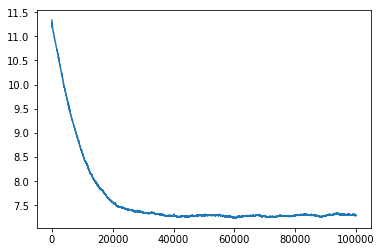

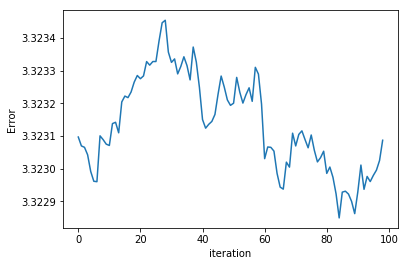

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.log(of_iter))
plt.figure()
plt.xlabel('iteration')
plt.ylabel('Log objective function')
plt.plot(error_iter[n_iter-100:n_iter-1])
plt.plot()
plt.xlabel('iteration')
plt.ylabel('Error')

The next algorithm is Batch Gradient. It is similar to Stochastic gradient, but at each iteration k observations are selected at random and k gradients are computed from them. Then, the gradient is computed as the average of the gradients. It reduces the variability introduced by Stochastic gradient but computionally is more expensive.

In [34]:
#Mini batch gradient descent

#gradient of the objective function. ridge regression
def ridge_regression_grad_of_sg(beta,x,y,rho):
    grad = -2. *  (y - np.dot(x,beta)) * x + 2. * rho * beta
    return np.squeeze(grad)

#number of observation and variables
nvar = 10
nobs = 500

#set seed for reproducibility purposes
np.random.seed(1)

#generates dataset
x0 = np.ones((nobs,1))
x1 = np.random.uniform(low=0, high=10, size=(nobs,nvar))
x = np.concatenate((x0,x1), axis=1)
beta = np.random.uniform(low=-2, high=2, size=(nvar+1,1))
eps = np.random.normal(loc=0, scale=1, size=(nobs,1))
y = np.dot(x,beta) + eps

rho = 1

beta_a = np.dot( np.dot( np.linalg.inv( np.dot(x.T,x) + rho*np.eye(nvar+1)), x.T), y)

import time

#set parameters
n_iter = 0 #number of iterations
max_iter = 100000 #number of maximum iterations
tol = 1e5 #initial value of tolerance
rho = 1
eps = 1e-5
alpha = 1e-5
x_shape = np.shape(x)
a = x_shape[0]
b = x_shape[1]
batch = 10

#initialize variables
of = 100
beta_init = np.zeros(nvar+1)
of_iter = np.zeros(max_iter)
tol_iter= np.zeros(max_iter)
alpha_iter = np.zeros(max_iter)
error_iter = np.zeros(max_iter)
gradient = np.zeros(nvar+1)

#initialize update rule variables
beta = np.copy(beta_init)

#algorithm
time_start = time.process_time()
for i in range(max_iter):
    if tol > eps:
    
        #step 1. select at random which samples are chosen to compute the gradient
        k = np.random.randint(b, size=batch)
        gradient[:] = 0
        for j in k:
            gradient += ridge_regression_grad_of_sg(beta,x[j,:],y[j],rho)
        gradient /= batch

        #step 2. compute descent direction and update coefficients
        d = - gradient
        beta = beta + alpha * d

        #step 3. stopping criteria
        of_new = ridge_regression_of(beta,x,y,rho)
        tol = np.absolute(of_new - of)
        of = of_new 

        #step 4. store results
        of_iter[i] = of
        tol_iter[i] = tol
        error_iter[i] = np.linalg.norm(beta_a - beta, ord = 2) / np.linalg.norm(beta_a, ord = 2)
        n_iter += 1

time = time.process_time() - time_start
print('finish run')

finish run


As explained before, using just some observations makes the gradient to have a large variability depending on the observation selected. Then it is a bad idea to use the gradient as the stopping criteria. In this case we use the change in the value of the objective function. The number of maximum iterations is set to 100.000 and it has achieve that value. This again is because of the variability at each iteration, which makes the objective function to oscillate at the end around 9.5 as we can see in the plot below. Unexpectedly, we get a large RMSE of the coefficients with a value of 0.543. I tried to modify the parameters but it did not result in a better performance. In terms of efficiency, it is obviously a bit slower than SG because of the inner loop included. The sample size of each iteration is stored at the varibale *batch* and the value is 10. Therefore, given that there have been 100.000 iterations, the number of calls to the gradient function is 100.000 x 10 which is 1 million, compared to only 100.000 call in SG.

In [35]:
print('RMSE of Mini Batch Gradient Descent method: {:.3f}'.format(np.sqrt(np.mean((beta_a.T - beta)**2))))
print('time elapsed =',time)
print('iterations = ',n_iter)
print('Tolerance =',tol[0][0])

RMSE of Mini Batch Gradient Descent method: 0.543
time elapsed = 31.859375
iterations =  100000
Tolerance = 1.694114962079766


The plots below shows the value of the objective function with each iteration and the value of the error in the last 100 iterations, which does not decrease nor increase having an oscillatory pattern.

<Figure size 432x288 with 0 Axes>

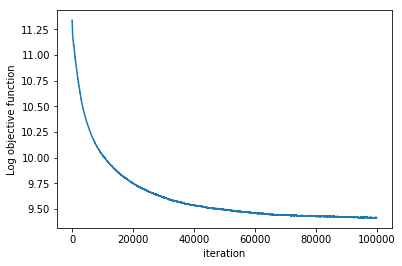

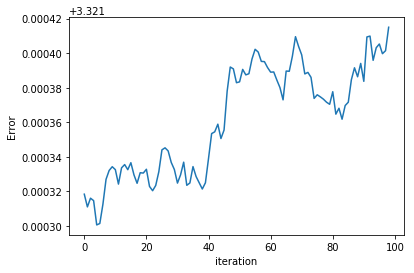

<Figure size 432x288 with 0 Axes>

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.log(of_iter))
plt.xlabel('iteration')
plt.ylabel('Log objective function')
plt.figure()
plt.plot(error_iter[n_iter-100:n_iter-1])
plt.xlabel('iteration')
plt.ylabel('Error')
plt.figure()

Finally, SG is modified adding the momentum term to the computation of the new coefficients in the updating step. This adds a new parameter, called gamma in the code and set to $\gamma = 10^{-3}$. As in the previous cases, the gradient is not a good stopping criteria so the difference in the objective function after each iteration is chosen.

In [37]:
#Mini batch sgd with momentum

#gradient of the objective function. ridge regression
def ridge_regression_grad_of_sg(beta,x,y,rho):
    grad = - 2. *  (y - np.dot(x,beta)) * x + 2. * rho * beta
    return np.squeeze(grad)

#number of observation and variables
nvar = 10
nobs = 500

#set seed for reproducibility purposes
np.random.seed(1)

#generates dataset
x0 = np.ones((nobs,1))
x1 = np.random.uniform(low=0, high=10, size=(nobs,nvar))
x = np.concatenate((x0,x1), axis=1)
beta = np.random.uniform(low=-2, high=2, size=(nvar+1,1))
eps = np.random.normal(loc=0, scale=1, size=(nobs,1))
y = np.dot(x,beta) + eps

rho = 1

beta_a = np.dot( np.dot( np.linalg.inv( np.dot(x.T,x) + rho*np.eye(nvar+1)), x.T), y)

import time

#set parameters
n_iter = 0 #number of iterations
max_iter = 100000 #number of maximum iterations
tol = 1e5 #initial value of tolerance
eps = 1e-6
alpha = 1e-5
gamma = 1e-3
x_shape = np.shape(x)
a = x_shape[0]
b = x_shape[1]

#initialize variables
of = 100
beta_init = np.zeros(nvar+1)
of_iter = np.zeros(max_iter)
tol_iter= np.zeros(max_iter)
alpha_iter = np.zeros(max_iter)
error_iter = np.zeros(max_iter)

#initialize update rule variables
beta_new = np.copy(beta_init)
beta = np.zeros(nvar+1)
beta_old = np.zeros(nvar+1)

#algorithm
time_start = time.process_time()
for i in range(max_iter):
    if tol > eps:
    
        #step 1. select at random sample is going to be used to compute the gradient
        k = np.random.randint(a)
        gradient_new = ridge_regression_grad_of_sg(beta,x[k,:],y[k],rho)

        #step 2. compute descent direction and update coefficients
        d = - gradient_new
        beta_new = beta + alpha * d + gamma * (beta - beta_old)

        #step 3. stopping criteria
        of_new = ridge_regression_of(beta,x,y,rho)
        tol = np.abs(of_new - of)
        of = of_new
        beta_old[:] = beta[:]
        beta[:] = beta_new[:]

        #step 4. store results
        of_iter[i] = ridge_regression_of(beta,x,y,rho)
        tol_iter[i] = tol
        error_iter[i] = np.linalg.norm(beta_a - beta, ord = 2) / np.linalg.norm(beta_a, ord = 2)
        n_iter += 1

time = time.process_time() - time_start

The number of iterations has been set again to 100.000 and the execution finished because it reached that number of iterations. Since the gradient is computed as in SG, the erratic pattern is found again and the conclusion drawn are the same as in the previous case. It took less time that Mini Batch but more time than SG, as it is expected because it has more operations per iteration than SG but less than Mini Batch. The number of gradient evaluations is 100.000, one per iteration. Looking at the RMSE we can see that it has not converged to the analytical value as it happened with SG.

In [38]:
print('RMSE of SDG with momentum: {:.3f}'.format(np.sqrt(np.mean((beta_a.T - beta)**2))))
print('time elapsed =',time)
print('iterations = ',n_iter)
print('Tolerance =',tol[0][0])

RMSE of SDG with momentum: 0.223
time elapsed = 19.8125
iterations =  100000
Tolerance = 1.0500377031471544


To finish, the next two plots show the Log of the objective function value at each iteration and the error at the last 500 iterations. The erratic behaviour can be observed over all the graph.

<Figure size 432x288 with 0 Axes>

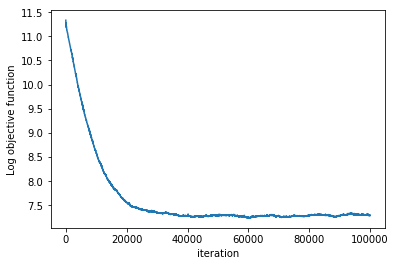

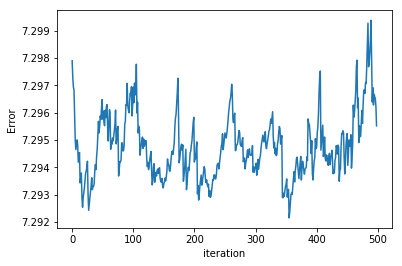

<Figure size 432x288 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.log(of_iter))
plt.xlabel('iteration')
plt.ylabel('Log objective function')
plt.figure()
plt.plot(np.log(of_iter[n_iter-500:n_iter-1]))
plt.xlabel('iteration')
plt.ylabel('Error')
plt.figure()